In [1]:
import pandas as pd

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import json

In [2]:
pd.options.display.max_colwidth = 100

# EDA of the original Train Set

In [4]:
records = []
with open('train.jsonl') as fp:
    for line in fp.readlines():
        records.append(json.loads(line))

In [5]:
original_train_df = pd.DataFrame.from_records(records, index='id').sort_index()

In [6]:
original_train_df.shape

(145449, 4)

In [34]:
original_train_df.head(10)

,claim,evidence,label,verifiable
id,,,,
3,Chris Hemsworth appeared in A Perfect Getaway.,"[[[15732, 19585, Chris_Hemsworth, 2]]]",SUPPORTS,VERIFIABLE
4,Chris Hemsworth disappeared in A Perfect Getaway.,"[[[15230, None, None, None]]]",NOT ENOUGH INFO,NOT VERIFIABLE
7,Roald Dahl is a writer.,"[[[15234, 18987, Roald_Dahl, 0]]]",SUPPORTS,VERIFIABLE
8,Roald Dahl is a governor.,"[[[15233, 18986, Roald_Dahl, 0]]]",REFUTES,VERIFIABLE
9,Ireland has relatively low-lying mountains.,"[[[15235, 18988, Ireland, 10]]]",SUPPORTS,VERIFIABLE
10,Ireland does not have relatively low-lying mountains.,"[[[15241, 18992, Ireland, 10]]]",REFUTES,VERIFIABLE
13,David Thewis has had many notable performances.,"[[[15238, None, None, None]]]",NOT ENOUGH INFO,NOT VERIFIABLE
14,There have been many notable performances by David Thewlis.,"[[[15240, 18990, David_Thewlis, 1]], [[15240, 18991, David_Thewlis, 2]]]",SUPPORTS,VERIFIABLE
17,Edward I of England responded to a second rebellion in 1282.,"[[[15244, 18995, Edward_I_of_England, 16]]]",SUPPORTS,VERIFIABLE


# Compile all together

## Read files

In [4]:
train_df = pd.read_json('train.json', orient='index').sort_index()
train_df['source'] = 'train'

In [5]:
dev_df = pd.read_json('devset.json', orient='index')
dev_df['source'] = 'dev'

In [6]:
test_df = pd.read_json('test-unlabelled.json', orient='index')
test_df['source'] = 'test'

## Generate list of all claims

In [7]:
cols = ['claim', 'source']
claims_df = pd.concat([train_df[cols], dev_df[cols], test_df[cols]]).sort_index()
claims_df.index.name = 'claim_id'
claims_df.to_csv('claims.csv')
claims_df.shape

(165447, 2)

In [22]:
claims_df.pivot_table(columns='source', aggfunc='count')

source,dev,test,train
claim,5001,14997,145449


In [20]:
claims_df.head()

,claim,source
claim_id,,
3,Chris Hemsworth appeared in A Perfect Getaway.,train
4,Chris Hemsworth disappeared in A Perfect Getaway.,train
6,Firefox is an application.,test
7,Roald Dahl is a writer.,train
8,Roald Dahl is a governor.,train


## Generate list of labelled claims

In [13]:
lclaims_df = pd.concat([train_df, dev_df]).sort_index()
lclaims_df.index.name = 'claim_id'

In [15]:
lclaims_df.shape

(150450, 4)

In [17]:
lclaims_df['evidence_docs'] = lclaims_df.evidence.apply(lambda x: {item[0] for item in x})
lclaims_df['evidence_doc_count'] = lclaims_df.evidence_docs.apply(lambda x: len(x))
lclaims_df['evidence_sentence_count'] = lclaims_df.evidence.apply(lambda x: len(x))

In [18]:
lclaims_df.head()

,claim,evidence,label,source,evidence_docs,evidence_doc_count,evidence_sentence_count
claim_id,,,,,,,
3,Chris Hemsworth appeared in A Perfect Getaway.,"[[Chris_Hemsworth, 2]]",SUPPORTS,train,{Chris_Hemsworth},1,1
4,Chris Hemsworth disappeared in A Perfect Getaway.,[],NOT ENOUGH INFO,train,{},0,0
7,Roald Dahl is a writer.,"[[Roald_Dahl, 0]]",SUPPORTS,train,{Roald_Dahl},1,1
8,Roald Dahl is a governor.,"[[Roald_Dahl, 0]]",REFUTES,train,{Roald_Dahl},1,1
9,Ireland has relatively low-lying mountains.,"[[Ireland, 10]]",SUPPORTS,train,{Ireland},1,1


### Evidence Counts

In [28]:
stat_df = lclaims_df.pivot_table(columns='label', index='evidence_doc_count',
                                 values='claim', aggfunc='count', fill_value=0, margins=True)
stat_df[stat_df.All > 100]

label,NOT ENOUGH INFO,REFUTES,SUPPORTS,All
evidence_doc_count,,,,
0,37306,0,0,37306
1,0,26806,67517,94323
2,0,3459,10754,14213
3,0,537,1575,2112
4,0,208,651,859
5,0,148,400,548
6,0,82,248,330
7,0,56,188,244
8,0,43,130,173


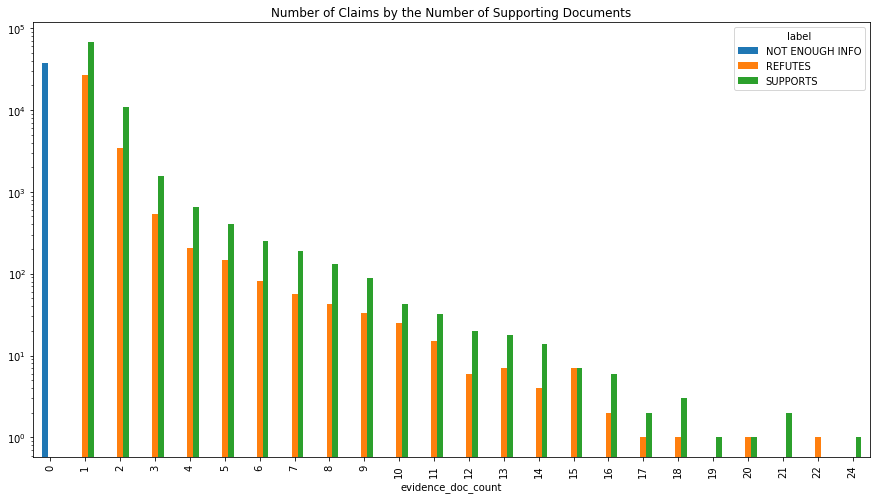

In [48]:
stat_df = lclaims_df.pivot_table(columns='label', index='evidence_doc_count',
                                 values='claim', aggfunc='count', fill_value=0)
stat_df.plot.bar(figsize=(15, 8), logy=True, title='Number of Claims by the Number of Supporting Documents')
plt.show()

### Most Popular Evidence

In [67]:
lclaims_df['evidence_set_str'] = lclaims_df.evidence_docs.astype(str)
mask = lclaims_df.label != 'NOT ENOUGH INFO'
evidence_stat = lclaims_df[mask].evidence_set_str.value_counts()
evidence_stat.index.name = 'evidence_set'
evidence_stat = evidence_stat.reset_index()
evidence_stat.head(20)

,evidence_set,evidence_set_str
0,{'Snoop_Dogg'},166
1,{'Wyatt_Earp'},151
2,{'United_Kingdom'},140
3,{'International_relations'},139
4,{'Marlon_Brando'},137
5,{'United_States'},132
6,{'Adele'},130
7,{'Abraham_Lincoln'},125
8,{'Miley_Cyrus'},120
9,{'Michael_Jackson'},119


In [73]:
evidence_stat = lclaims_df[mask].pivot_table(index=['evidence_set_str', 'evidence_doc_count'], 
                                             values='claim', aggfunc='count').reset_index()

### Claims with Multiple evidence

In [76]:
evidence_stat[evidence_stat.evidence_doc_count > 1].sort_values('claim', ascending=False).head(20)

,evidence_set_str,evidence_doc_count,claim
5018,"{'George_R._R._Martin', 'A_Song_of_Ice_and_Fire'}",2,42
1408,"{'Audrey_Horne', 'Pilot_-LRB-Twin_Peaks-RRB-'}",2,32
5935,"{'Hot_-LRB-Mel_B_album-RRB-', 'Mel_B'}",2,26
5343,"{'Grace_Jones', 'Warm_Leatherette_-LRB-album-RRB-'}",2,26
6648,"{'Jay_Baruchel', 'Gift_of_the_Night_Fury'}",2,23
10896,"{'Richard_Nixon', 'Pat_Nixon'}",2,22
6177,"{'In_&_Out_-LRB-film-RRB-', 'Joan_Cusack'}",2,20
7901,"{'Lindsay_Anderson', 'This_Sporting_Life'}",2,20
5508,"{'Grégory_Levasseur', 'Furia_-LRB-film-RRB-'}",2,19
1074,"{'Ann_Romney', 'Mitt_Romney'}",2,19


In [77]:
evidence_stat[evidence_stat.evidence_doc_count > 3].sort_values('claim', ascending=False).head(20)

,evidence_set_str,evidence_doc_count,claim
10877,"{'Richard_Gere', 'Days_of_Heaven', 'American_Gigolo', 'An_Officer_and_a_Gentleman'}",4,7
7503,"{'Kristen_Wiig', 'America_Ferrera', 'Gift_of_the_Night_Fury', 'Gerard_Butler', 'Jonah_Hill', 'Cr...",9,7
3568,"{'Days_Before_Rodeo', 'Travis_Scott', 'Birds_in_the_Trap_Sing_McKnight', 'Rodeo_-LRB-Travis_Scot...",5,7
13434,"{'The_Trap_-LRB-1966_film-RRB-', 'Oliver_Reed', 'Gladiator_-LRB-2000_film-RRB-', 'Castaway_-LRB-...",4,5
1884,"{'Bill_Murray', 'Owen_Wilson', 'Luke_Wilson', 'Danny_Glover', 'The_Royal_Tenenbaums', 'Ben_Still...",7,5
403,"{'A_Feast_for_Crows', 'A_Clash_of_Kings', 'A_Storm_of_Swords', 'A_Game_of_Thrones', 'Gendry'}",5,5
8623,"{'Max_Minghella', 'Jeff_Bridges', 'Danny_Huston', 'How_to_Lose_Friends_&_Alienate_People_-LRB-fi...",5,4
3747,"{'Diane_Kruger', 'Jake_Abel', 'Max_Irons', 'William_Hurt', 'The_Host_-LRB-2013_film-RRB-', 'Saoi...",6,4
7446,"{'Kirk_Douglas', 'Seven_Days_in_May', 'Ava_Gardner', 'Burt_Lancaster'}",4,4
4876,"{'Gabrielle_Union', 'Deliver_Us_from_Eva', 'Almost_Christmas_-LRB-film-RRB-', 'Bad_Boys_II', 'Br...",6,4


In [78]:
lclaims_df[lclaims_df.evidence_doc_count > 10].head(20)

,claim,evidence,label,source,evidence_docs,evidence_doc_count,evidence_sentence_count,evidence_set_str
claim_id,,,,,,,,
877,Keith Urban is a singer.,"[[Break_on_Me, 1], [Keith_Urban_-LRB-1991_album-RRB-, 0], [Keith_Urban, 18], [Golden_Road_-LRB-a...",SUPPORTS,train,"{Ripcord_-LRB-album-RRB-, Break_on_Me, But_for_the_Grace_of_God, The_Ranch_-LRB-band-RRB-, Stupi...",11,22,"{'Ripcord_-LRB-album-RRB-', 'Break_on_Me', 'But_for_the_Grace_of_God', 'The_Ranch_-LRB-band-RRB-..."
1885,Leonardo DiCaprio is an actor.,"[[Blood_Diamond, 0], [Leonardo_DiCaprio, 8], [Leonardo_DiCaprio, 1], [Inception, 1], [Shutter_Is...",SUPPORTS,train,"{The_Departed, Titanic_-LRB-1997_film-RRB-, Blood_Diamond, The_Great_Gatsby_-LRB-2013_film-RRB-,...",24,40,"{'The_Departed', 'Titanic_-LRB-1997_film-RRB-', 'Blood_Diamond', 'The_Great_Gatsby_-LRB-2013_fil..."
7253,Laurence Fishburne acted in a movie.,"[[Man_of_Steel_-LRB-film-RRB-, 4], [Othello_-LRB-1995_film-RRB-, 0], [Academy_Award_for_Best_Act...",SUPPORTS,train,"{Apocalypse_Now, Batman_v_Superman-COLON-_Dawn_of_Justice, Othello_-LRB-1995_film-RRB-, What's_L...",11,27,"{'Apocalypse_Now', 'Batman_v_Superman-COLON-_Dawn_of_Justice', 'Othello_-LRB-1995_film-RRB-', ""W..."
7540,Scarlett Johansson is an actress.,"[[Lucy_-LRB-2014_film-RRB-, 0], [Scarlett_Johansson, 3], [Ghost_World_-LRB-film-RRB-, 0], [Manny...",SUPPORTS,train,"{Match_Point, Vicky_Cristina_Barcelona, Girl_with_a_Pearl_Earring_-LRB-film-RRB-, Ghost_in_the_S...",21,38,"{'Match_Point', 'Vicky_Cristina_Barcelona', 'Girl_with_a_Pearl_Earring_-LRB-film-RRB-', 'Ghost_i..."
7541,Scarlett Johansson is an actress in films.,"[[Girl_with_a_Pearl_Earring_-LRB-film-RRB-, 16], [Lucy_-LRB-2014_film-RRB-, 0], [Ghost_World_-LR...",SUPPORTS,train,"{Match_Point, Vicky_Cristina_Barcelona, Don_Jon, Ghost_in_the_Shell_-LRB-2017_film-RRB-, Ghost_W...",20,40,"{'Match_Point', 'Vicky_Cristina_Barcelona', 'Don_Jon', 'Ghost_in_the_Shell_-LRB-2017_film-RRB-',..."
7623,Slovakia is a warship.,"[[Slovakia, 4], [Democracy_Index, 0], [Slovakia, 19], [Social_security, 6], [Slovakia, 26], [Slo...",REFUTES,train,"{Bratislava, List_of_countries_by_real_GDP_growth_rate, Slovakia, Austria, Council_of_Europe, So...",16,39,"{'Bratislava', 'List_of_countries_by_real_GDP_growth_rate', 'Slovakia', 'Austria', 'Council_of_E..."
7747,Julie Christie starred in a film.,"[[The_Go-Between_-LRB-1971_film-RRB-, 0], [Away_from_Her, 0], [Julie_Christie, 8], [Darling_-LRB...",SUPPORTS,train,"{Far_from_the_Madding_Crowd_-LRB-1967_film-RRB-, Heaven_Can_Wait_-LRB-1978_film-RRB-, Julie_Chri...",13,17,"{'Far_from_the_Madding_Crowd_-LRB-1967_film-RRB-', 'Heaven_Can_Wait_-LRB-1978_film-RRB-', 'Julie..."
7886,George W. Bush was a president.,"[[George_W._Bush, 10], [George_W._Bush, 28], [Barbara_Bush, 1], [George_W._Bush, 5], [United_Sta...",SUPPORTS,train,"{Laura_Bush, Patriot_Act, Prescott_Bush, Bush_Doctrine, United_States_presidential_election,_200...",14,30,"{'Laura_Bush', 'Patriot_Act', 'Prescott_Bush', 'Bush_Doctrine', 'United_States_presidential_elec..."
8089,Gennady Golovkin boxes.,"[[Gennady_Golovkin, 5], [Interim_championship, 0], [Milton_Núñez_-LRB-boxer-RRB-, 1], [Gennady...",SUPPORTS,train,"{International_Boxing_Federation, Gennady_Golovkin, World_Boxing_Council, David_Lemieux_-LRB-box...",16,28,"{'International_Boxing_Federation', 'Gennady_Golovkin', 'World_Boxing_Council', 'David_Lemieux_-..."


In [79]:
lclaims_df.to_json('l_claims.json')